### Load Modules

In [1]:
# Restart the kernel
import os
import dill as pickle
current_dir ='../../../'
os.chdir(current_dir)

from src.codes.basic import *
from src.codes.utils.fem_utils_HC import *
from src.codes.utils.plot_files.plot_utils import OneDPlot as plot
from src.codes.utils.plot_files.plot_utils import data_stats
from src.codes.utils.rom_utils import *

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM, probdata, ROM_simulation
import src.codes.reductor.rom_class_ms as rom_class
import src.codes.algorithms.deim as deim_module
from importlib import reload
reload(deim_module)
import ptitprince as pt
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 100

### Load data

In [3]:
filename_dataC = 'examples/heat_conduction/OneD_heat_conduction/data/DataClass.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask

N_snap,_ = np.shape(NLS)
print(N_snap)

100


### Plot data

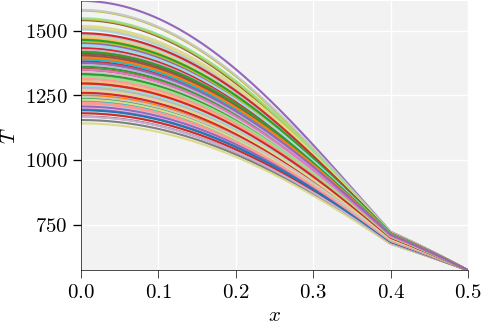

In [4]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(N_snap):
    Plot = plot(d.xi[0], NLS[i], ax=ax)
    Plot.line_()
plt.show()

## DEIM Hyper-reduction

### Train-Test split

In [5]:
# You may choose to define you train and test set data too!
# train_mask, test_mask = train_test_split(N_snap)

NLS_train = NLS[train_mask][:,d.mask]
param_list_train = param_list[train_mask]

NLS_test = NLS[test_mask][:,d.mask]

### Mean Subtraction

In [6]:
NLS_train_mean = np.mean(NLS_train,axis=0)
NLS_train_mean.shape
NLS_train_ms = NLS_train - NLS_train_mean

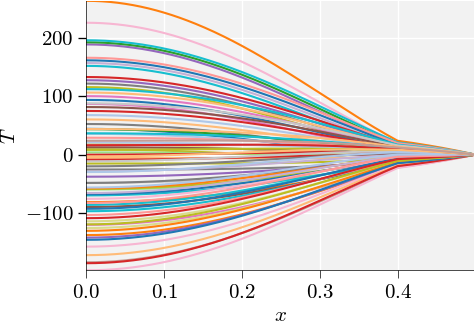

In [7]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(80):
    Plot = plot(d.xi[0][d.mask], NLS_train_ms[i], ax=ax)
    Plot.line_()
plt.show()


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

Selected modes: 4


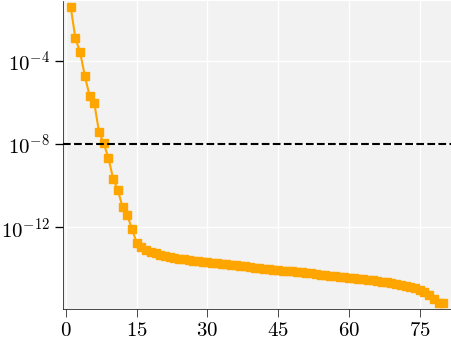

In [8]:
# plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS_train_ms, tolerance=1e-8,modes=False)
n_sel += -5
print(f"Selected modes: {n_sel}")
V_sel = U[:, :n_sel]

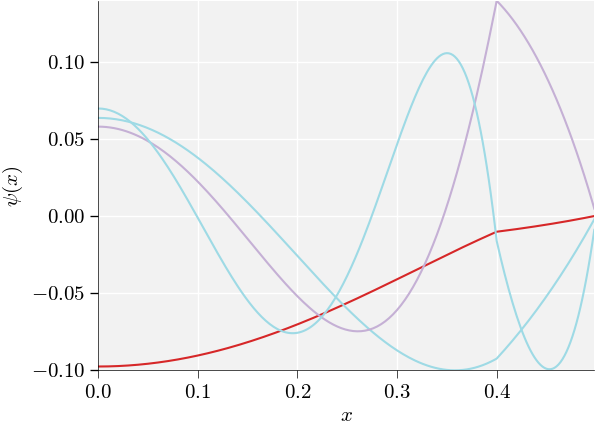

In [9]:
fig, ax = plt.subplots()

for i in range(n_sel):
    Plot = plot(d.xi[0][d.mask], V_sel[:,i], ax=ax)
    Plot.line_()
    
Plot.ax.set_xlabel('$x$')
Plot.ax.set_ylabel('$\psi(x)$')

plt.show()

### Step 2: Perform SVD on the force snapshots

In [10]:
len(Data_cls.rhs[0])

250

In [11]:
d.xi[0].shape

(251,)

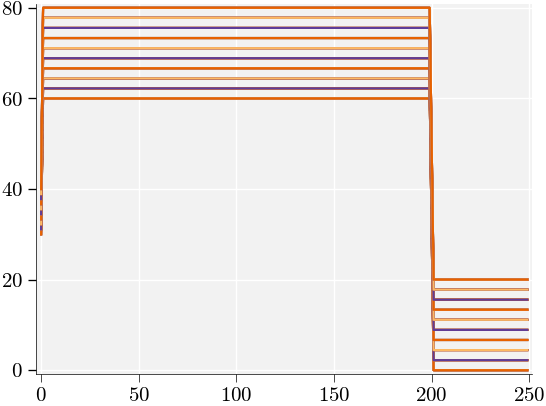

In [12]:
F_nl = np.asarray(Data_cls.rhs)

fig, ax = plt.subplots()
for i in range(len(F_nl)):
    ax.plot(F_nl[i])

Selected modes:2


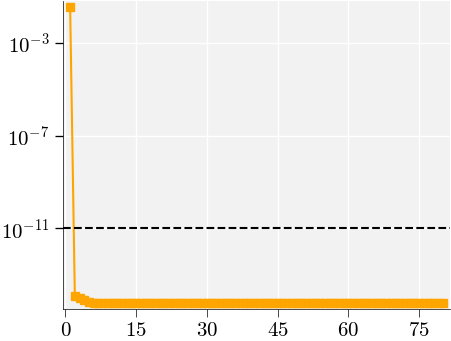

In [13]:
# Force snapshots
F_nl = np.asarray(Data_cls.rhs)

deim = deim_module.deim(d,F_nl,train_mask,param_list,V_sel,NLS_train_ms,d.mask,tol_f=1e-11, extra_modes=0)

tic_h_setup_b = time.time()
deim.select_elems()
toc_h_setup_b = time.time()

xi = deim.xi

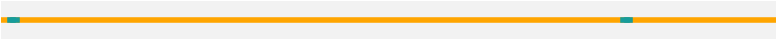

Fraction of total elements active in the ROM: 1.6%


In [14]:
plot(np.arange(d.ncells[0]), xi, ax="").element_()
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

### Specifiy the subtracted mean

In [15]:
Data_cls.mean = NLS_train_mean


### ROM Simulation

In [16]:
ROM_h = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi, deim=deim)#, N_rom_snap=1)
ROM_h.run_simulation_h_deim()

In [17]:
eval_rom = True
if eval_rom:
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi)#, N_rom_snap=1)
    ROM.run_simulation()

### Performance Statistics

In [18]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up_h
ROM_relative_error_h = ROM_h.rom_error

In [19]:
if eval_rom:
    NLS_rom = np.asarray(ROM.NL_solutions_rom)
    ROM_speed_up = ROM.speed_up
    ROM_relative_error = ROM.rom_error

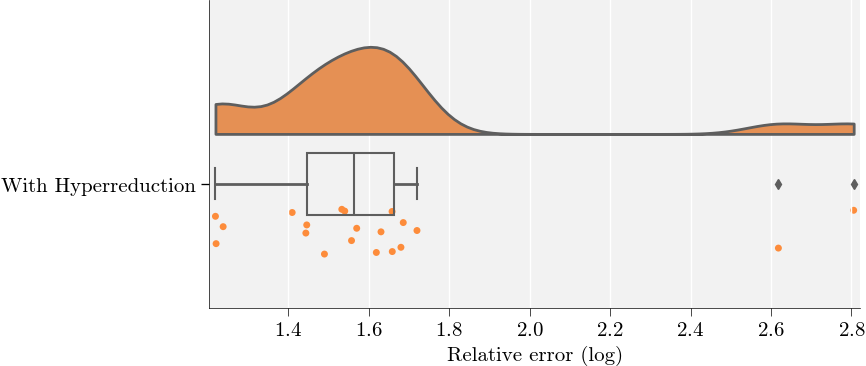

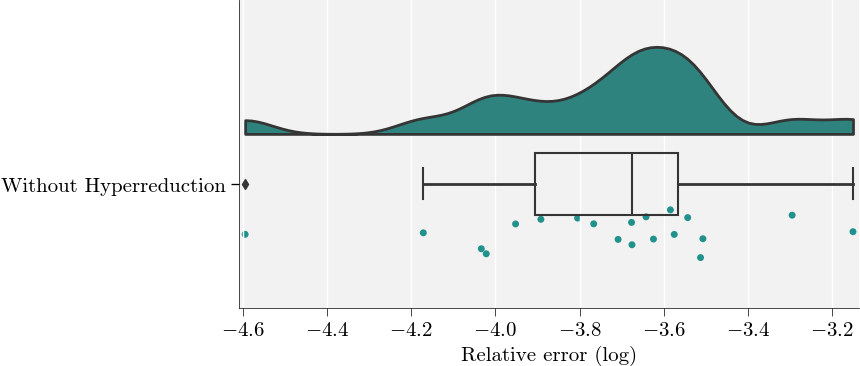

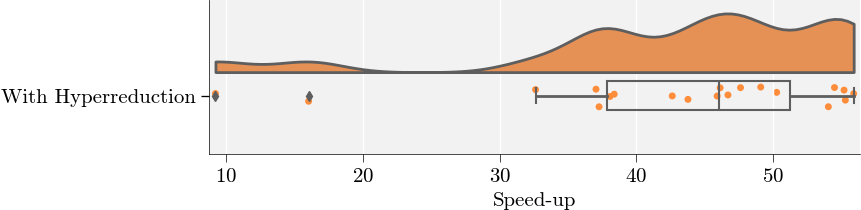

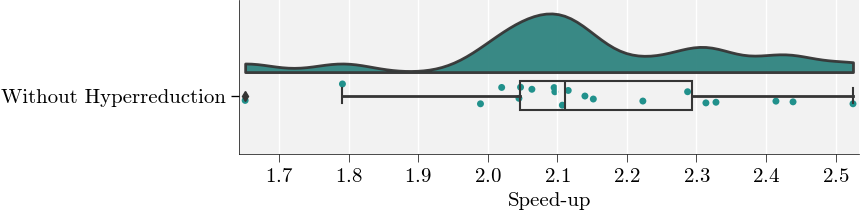

In [20]:
df_A = pd.DataFrame({'':'With Hyperreduction','Relative error (log)':np.log10(ROM_relative_error_h)})
df_B = pd.DataFrame({'':'Without Hyperreduction','Relative error (log)':np.log10(ROM_relative_error)})

# Combine the DataFrames
df = pd.concat([df_A, df_B])

fig, ax = plt.subplots(figsize=(8.4, 4))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df_A, palette = "Oranges", bw = 0.2,
    width_viol = .7, ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.25, linewidth=2, point_size =5.0, move=0.2)
plt.show()


fig, ax = plt.subplots(figsize=(8, 4))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df_B, palette = "viridis", bw = 0.2,
    width_viol = .7, ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.25, linewidth=2, point_size =5.0, move=0.2)
plt.show()


# ===

df_C = pd.DataFrame({'':'With Hyperreduction','Speed-up':ROM_speed_up_h})
df_D = pd.DataFrame({'':'Without Hyperreduction','Speed-up':ROM_speed_up})

# Combine the DataFrames
df2 = pd.concat([df_C, df_D])

fig, ax = plt.subplots(figsize=(8.4, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_C, palette = "Oranges",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=1.0, width_box = 0.25, linewidth=2, point_size =5.0)

fig, ax = plt.subplots(figsize=(8, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_D, palette = "viridis",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=0.95, width_box = 0.25, linewidth=2, point_size =5.0)
plt.show()

In [21]:
# data_stats(ROM_speed_up_h, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
# data_stats(np.log10(ROM_relative_error_h), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");

In [22]:
# data_stats(ROM_speed_up, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
# data_stats(np.log10(ROM_relative_error), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");

: 